In [1]:
import numpy as np
import pandas as pd

from treen import load_example
import enflow as ef
import gymnasium as gym

### Step 1) Define the energy system 

In [2]:
df = load_example('gefcom2014-wind')

windfarms = []
for name in df.columns.levels[0]:
    windfarms.append(ef.WindFarm(capacity=1, name=name))

portfolio = ef.Portfolio(assets=windfarms)

In [3]:
df.head()

Site1                      \
                                            Power       U10      U100   
ref_datetime        valid_datetime                                      
2012-01-01 01:00:00 2012-01-01 01:00:00  0.000000  2.124600  2.864280   
                    2012-01-01 02:00:00  0.054879  2.521695  3.344859   
                    2012-01-01 03:00:00  0.110234  2.672210  3.508448   
                    2012-01-01 04:00:00  0.165116  2.457504  3.215233   
                    2012-01-01 05:00:00  0.156940  2.245898  2.957678   

                                                                Site2  \
                                              V10      V100     Power   
ref_datetime        valid_datetime                                      
2012-01-01 01:00:00 2012-01-01 01:00:00 -2.681966 -3.666076  0.596273   
                    2012-01-01 02:00:00 -1.796960 -2.464761  0.411180   
                    2012-01-01 03:00:00 -0.822516 -1.214093  0.167243   
                    2012-01-01 04:00:00 -0.143642 -0.355546  0.037326   
                    2012-01-01 05:00:00  0.389576  0.332701  0.051206   

                                                                       \
                                              U10      U100       V10   
ref_datetime        valid_datetime                                      
2012-01-01 01:00:00 2012-01-01 01:00:00 -0.171642 -0.112594 -5.466031   
                    2012-01-01 02:00:00 -0.088859 -0.014100 -4.643205   
                    2012-01-01 03:00:00 -0.246014 -0.225238 -3.613395   
                    2012-01-01 04:00:00 -0.680738 -0.772046 -2.919615   
                    2012-01-01 05:00:00 -1.261106 -1.487537 -2.619786   

                                                   ... Site9            \
                                             V100  ... Power       U10   
ref_datetime        valid_datetime                 ...                   
2012-01-01 01:00:00 2012-01-01 01:00:00 -7.101347  ...   0.0  1.903254   
                    2012-01-01 02:00:00 -5.896778  ...   0.0  2.173296   
                    2012-01-01 03:00:00 -4.489369  ...   0.0  2.312744   
                    2012-01-01 04:00:00 -3.598824  ...   0.0  2.217565   
                    2012-01-01 05:00:00 -3.244667  ...   0.0  1.900598   

                                                                       \
                                             U100       V10      V100   
ref_datetime        valid_datetime                                      
2012-01-01 01:00:00 2012-01-01 01:00:00  2.516723 -1.495002 -2.078063   
                    2012-01-01 02:00:00  2.837109 -0.643641 -1.006914   
                    2012-01-01 03:00:00  3.034096  0.136595 -0.015490   
                    2012-01-01 04:00:00  2.941829  0.797156  0.823531   
                    2012-01-01 05:00:00  2.559177  1.285656  1.471102   

                                           Site10                      \
                                            Power       U10      U100   
ref_datetime        valid_datetime                                      
2012-01-01 01:00:00 2012-01-01 01:00:00  0.594361  1.655790  2.024257   
                    2012-01-01 02:00:00  0.569679  2.178609  2.623141   
                    2012-01-01 03:00:00  0.330539  2.228633  2.645217   
                    2012-01-01 04:00:00  0.211308  2.077232  2.432947   
                    2012-01-01 05:00:00  0.172140  1.814716  2.097844   

                                                             
                                              V10      V100  
ref_datetime        valid_datetime                           
2012-01-01 01:00:00 2012-01-01 01:00:00 -4.649593 -5.992232  
                    2012-01-01 02:00:00 -4.184944 -5.318086  
                    2012-01-01 03:00:00 -3.242442 -4.052232  
                    2012-01-01 04:00:00 -2.345085 -2.913831  
                    2012-01-01 05:00:00 -1.577625 -1.976100  

[5 rows x 50 columns]

In [4]:
dataset = ef.Dataset(name="gefcom2024",
                     description="Data provided by the organisers of HEFTCom2024. Participants are free to use additional external data.",
                     energy_system=portfolio,
                     data={"data_gefcom2014_wind": df})

### Step 2) Define state, exogeneous and action spaces

In [5]:
state_space = ef.DataFrameSpace({asset.name: {
    'U10': gym.spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32),
    'V10': gym.spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32),
    'U100': gym.spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32),
    'V100': gym.spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32),
    'Power': gym.spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32)
} for asset in portfolio.assets})

action_space = ef.DataFrameSpace({asset.name: {
    f"Quantile_forecast_{i+1}": gym.spaces.Box(low=0, high=1, shape=(1,)) for i in range(99)
} for asset in portfolio.assets})


In [6]:
state_space.sample(n_rows=3)

Site1                                            Site10            \
      Power       U10      U100       V10      V100     Power       U10   
0  0.296354  0.169780  0.289527  0.145741  0.339475  0.646338 -1.142199   
1  0.159414 -0.612152  0.564730  1.249009  0.068293  0.180641  0.637857   
2  0.082790 -1.912824 -1.553707  0.521232  0.249474  0.628877  0.420294   

                                 ...     Site8                                \
       U100       V10      V100  ...     Power       U10      U100       V10   
0 -0.999819 -0.238728 -1.383762  ...  0.133166 -0.923158 -0.690573  0.300898   
1 -0.273661 -0.666385  0.721166  ...  0.259436 -0.239721  0.257541 -0.446691   
2 -0.054387  0.636739 -0.559994  ...  0.759944 -0.486978  1.379630 -0.349310   

                Site9                                          
       V100     Power       U10      U100       V10      V100  
0  0.255345  0.455090 -0.919247 -1.126579 -1.075945  0.037379  
1  0.935989  0.250406  0.167500  0.807626 -0.374514  0.638981  
2  0.275785  0.143044  0.258098 -1.586087  0.944741 -0.674976  

[3 rows x 50 columns]

In [7]:
action_space.sample(n_rows=3)

Site1                                            \
  Quantile_forecast_1 Quantile_forecast_10 Quantile_forecast_11   
0            0.967328             0.791389             0.269525   
1            0.451024             0.536145             0.659264   
2            0.182134             0.058955             0.578697   

                                                                  \
  Quantile_forecast_12 Quantile_forecast_13 Quantile_forecast_14   
0             0.029595             0.129156             0.375430   
1             0.581714             0.564848             0.179841   
2             0.781927             0.121902             0.179242   

                                                                  \
  Quantile_forecast_15 Quantile_forecast_16 Quantile_forecast_17   
0             0.965439             0.983346             0.019929   
1             0.980388             0.774404             0.661128   
2             0.886640             0.192774             0.724284   

                        ...                Site9                       \
  Quantile_forecast_18  ... Quantile_forecast_90 Quantile_forecast_91   
0             0.117163  ...             0.178891             0.377465   
1             0.120007  ...             0.553731             0.454351   
2             0.392303  ...             0.394786             0.866239   

                                                                  \
  Quantile_forecast_92 Quantile_forecast_93 Quantile_forecast_94   
0             0.561239             0.679768             0.529217   
1             0.248028             0.004378             0.649566   
2             0.601465             0.503850             0.484884   

                                                                  \
  Quantile_forecast_95 Quantile_forecast_96 Quantile_forecast_97   
0             0.702258             0.167443             0.709129   
1             0.600185             0.655074             0.985787   
2             0.290025             0.374094             0.527303   

                                             
  Quantile_forecast_98 Quantile_forecast_99  
0             0.937487             0.475530  
1             0.399557             0.920098  
2             0.500543             0.938327  

[3 rows x 990 columns]

### Step 3) Create environment

In [108]:
class GEFCom2014Wind(gym.Env):
    def __init__(self, dataset: ef.Dataset): 
        self.dataset = dataset
        self.data = dataset.data["data_gefcom2014_wind"]
        self.input = ["U10", "V10", "U100", "V100"]
        self.target = ["Power"]
        self.state_space = state_space
        self.action_space = action_space
        self.idx_counter = 0

        self.train = [["2012-01-01 01:00:00", "2012-10-01 00:00:00"],
                      ["2012-10-01 01:00:00", "2012-11-01 00:00:00"],
                      ["2012-11-01 01:00:00", "2012-12-01 00:00:00"],
                      ["2012-12-01 01:00:00", "2013-01-01 00:00:00"],
                      ["2013-01-01 01:00:00", "2013-02-01 00:00:00"],
                      ["2013-02-01 01:00:00", "2013-03-01 00:00:00"],
                      ["2013-03-01 01:00:00", "2013-04-01 00:00:00"],
                      ["2013-04-01 01:00:00", "2013-05-01 00:00:00"],
                      ["2013-05-01 01:00:00", "2013-06-01 00:00:00"],
                      ["2013-06-01 01:00:00", "2013-07-01 00:00:00"],
                      ["2013-07-01 01:00:00", "2013-08-01 00:00:00"],
                      ["2013-08-01 01:00:00", "2013-09-01 00:00:00"],
                      ["2013-09-01 01:00:00", "2013-10-01 00:00:00"],
                      ["2013-10-01 01:00:00", "2013-11-01 00:00:00"],
                      ["2013-11-01 01:00:00", "2013-12-01 00:00:00"]]
        
        self.test = [["2012-10-01 01:00:00", "2012-11-01 00:00:00"],
                     ["2012-11-01 01:00:00", "2012-12-01 00:00:00"],
                     ["2012-12-01 01:00:00", "2013-01-01 00:00:00"],
                     ["2013-01-01 01:00:00", "2013-02-01 00:00:00"],
                     ["2013-02-01 01:00:00", "2013-03-01 00:00:00"],
                     ["2013-03-01 01:00:00", "2013-04-01 00:00:00"],
                     ["2013-04-01 01:00:00", "2013-05-01 00:00:00"],
                     ["2013-05-01 01:00:00", "2013-06-01 00:00:00"],
                     ["2013-06-01 01:00:00", "2013-07-01 00:00:00"],
                     ["2013-07-01 01:00:00", "2013-08-01 00:00:00"],
                     ["2013-08-01 01:00:00", "2013-09-01 00:00:00"],
                     ["2013-09-01 01:00:00", "2013-10-01 00:00:00"],
                     ["2013-10-01 01:00:00", "2013-11-01 00:00:00"],
                     ["2013-11-01 01:00:00", "2013-12-01 00:00:00"],
                     ["2013-12-01 01:00:00", "2014-01-01 00:00:00"]]

        self.n_steps = len(self.test)

    def reset(self, return_dataframe=False):
        self.idx_counter = 0
        initial_dataframe = self.data.loc[(self.data.index.get_level_values('valid_datetime') >= self.train[self.idx_counter][0]) &
                                          (self.data.index.get_level_values('valid_datetime') <= self.train[self.idx_counter][1])]

        first_input = self.data.loc[(self.data.index.get_level_values('valid_datetime') >= self.test[self.idx_counter][0]) &
                                    (self.data.index.get_level_values('valid_datetime') <= self.test[self.idx_counter][1]),
                                     pd.IndexSlice[:, self.input]]

        return first_input, initial_dataframe

    def step(self, action=None):

        if self.idx_counter+1 < self.n_steps:
            next_input = df.loc[(df.index.get_level_values('valid_datetime') >= self.test[self.idx_counter+1][0]) &
                                    (df.index.get_level_values('valid_datetime') <= self.test[self.idx_counter+1][1]),
                                    pd.IndexSlice[:, self.input]] 

            next_target = df.loc[(df.index.get_level_values('valid_datetime') >= self.train[self.idx_counter+1][0]) &
                                 (df.index.get_level_values('valid_datetime') <= self.train[self.idx_counter+1][1]),
                                  pd.IndexSlice[:, self.target]]

            done = False
            
            self.idx_counter += 1

            return next_input, next_target, done
    
        elif self.idx_counter+1 == self.n_steps:
            next_target = df.loc[(df.index.get_level_values('valid_datetime') >= self.test[self.idx_counter][0]) &
                                 (df.index.get_level_values('valid_datetime') <= self.test[self.idx_counter][1]),
                                  pd.IndexSlice[:, self.target]]
            
            done = True

            self.idx_counter += 1
            
            return None, next_target, done
        


### Step 4) Define the objective


In [109]:
from enflow.problems.objective import PinballLoss

obj = PinballLoss(quantiles=[0.1, 0.5, 0.9])

### Step 5) Create the model


In [110]:
import lightgbm as lgb
import pandas as pd

class CatboostGEFCom2014(ef.Predictor):
    def __init__(self, quantiles=None):
        """
        Initialize the Predictor class.
        
        Args:
            quantiles (list): List of quantiles for which to create separate models.
                              Example: [0.1, 0.5, 0.9]
        """
        self.models = {}  # Dictionary to hold models for each site and quantile
        self.quantiles = [0.1, 0.5, 0.9] 
        
    def train(self, features: pd.DataFrame, target: pd.DataFrame, **kwargs):
        """
        Train separate LightGBM models for each site and quantile.
        
        Args:
            features (pd.DataFrame): Multi-indexed dataframe where the top-level index corresponds to sites.
            target (pd.DataFrame): The target dataframe (y), also multi-indexed by site.
            kwargs: Additional parameters to pass to the LightGBMRegressor model.
        """
        # Get the list of unique sites from the multi-index (top level)
        sites = features.columns.get_level_values(0).unique()
        feature_names = features.columns.get_level_values(1).unique()

        # Loop over each site
        for site in sites:
            # Extract the features and target for the current site
            site_features = features.xs(site, axis=1, level=0)
            site_target = target.xs(site, axis=1, level=0)

            # Loop over each quantile
            for quantile in self.quantiles:
                # Initialize a LightGBM model for this quantile
                params = {'objective': 'quantile', 'alpha': quantile, "verbose": -1}
                params.update(kwargs)  # Add any additional LightGBM parameters
                
                model = lgb.LGBMRegressor(**params)
                
                # Train the model on the site's data
                model.fit(site_features, site_target)
                
                # Store the trained model with a key (site, quantile)
                self.models[(site, quantile)] = model
                
    def predict(self, features: pd.DataFrame):
        """
        Make predictions for all sites and quantiles using the trained models.

        Args:
            features (pd.DataFrame): The feature dataframe (X), multi-indexed by site.

        Returns:
            pd.DataFrame: Multi-indexed DataFrame with predictions for each site and quantile.
        """
        # Get the list of unique sites from the multi-index (top level)
        sites = features.columns.get_level_values(0).unique()

        # Create a dictionary to store predictions
        predictions_dict = {}

        # Loop over each site and quantile
        for site in sites:
            # Extract the features for the current site
            site_features = features.xs(site, axis=1, level=0)

            for quantile in self.quantiles:
                # Check if the model for the given site and quantile exists
                if (site, quantile) not in self.models:
                    raise ValueError(f"No trained model for site '{site}' and quantile '{quantile}'.")

                # Make predictions using the stored model
                model = self.models[(site, quantile)]
                site_predictions = model.predict(site_features)

                # Store predictions in the dictionary with multi-index structure (site, quantile)
                predictions_dict[(site, quantile)] = site_predictions

        # Convert the predictions dictionary to a pandas DataFrame with multi-index columns
        predictions_df = pd.DataFrame(predictions_dict)

        # Set the multi-index columns (site, quantile) for the predictions DataFrame
        predictions_df.columns = pd.MultiIndex.from_tuples(predictions_df.columns, names=["Site", "Quantile"])

        return predictions_df


    def predict(self, features: pd.DataFrame):
        """
        Make predictions for a specific site and quantile using the trained model.
        
        Args:
            features (pd.DataFrame): The feature dataframe (X), multi-indexed by site.
            site (str): The site for which to make predictions.
            quantile (float): The quantile for which to make predictions.
        
        Returns:
            np.array: Predictions from the model.
        """

        # Create a nested dictionary to store predictions
        predictions = {}

        # Extract the features for the specific site
        sites = features.columns.get_level_values(0).unique()

        # Loop over each site and quantile
        for site in sites:
            # Extract the features for the current site
            site_features = features.xs(site, axis=1, level=0)

            # Initialize an inner dictionary for each site

            for quantile in self.quantiles:
                # Check if the model for the given site and quantile exists
                if (site, quantile) not in self.models:
                    raise ValueError(f"No trained model for site '{site}' and quantile '{quantile}'.")

                # Make predictions using the stored model
                model = self.models[(site, quantile)]
                site_predictions = model.predict(site_features)

                # Store the predictions under the quantile for the current site
                predictions[(site, f"quantile_{round(100*quantile)}")] = site_predictions

        # Convert the nested dictionary to a DataFrame with multi-index columns
        predictions = pd.DataFrame.from_dict(predictions)
        predictions.index = features.index
        
        return predictions


In [111]:
# 3) Finally compare with the performance of the participants in the competition


### Step 6) Run the sequential decision loop and evaluate performance

In [117]:
env = GEFCom2014Wind(dataset=dataset)
next_input, initial_df = env.reset()

initial_input = initial_df.loc[:,(slice(None), env.input)]
initial_target = initial_df.loc[:,(slice(None), env.target)]

In [118]:
predictor = CatboostGEFCom2014()
predictor.train(features=initial_input, target=initial_target)

In [119]:
len(next_input), len(next_target), len(prediction)

(744, 744, 744)

In [120]:
losses = []
for i in range(env.n_steps):
    prediction = predictor.predict(features=next_input)
    next_input, next_target, done = env.step()
    loss = obj.score(next_target, prediction)
    losses.append(loss)

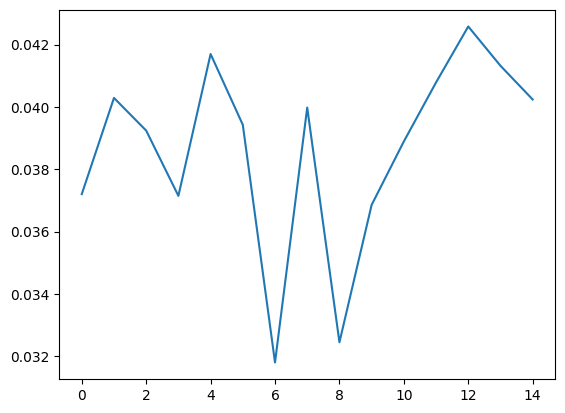

In [121]:
import matplotlib.pyplot as plt
plt.plot(losses)